In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from tslearn.clustering import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm 
import pickle

In [3]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

In [4]:
df_solar_satellite = pd.read_csv('../../1_data_analysis_and_preproc/intermediate/solar/solar_satellite_merged.csv')

In [5]:
df_solar_satellite.head()

,asset_id,read_at,ac_power,ac_voltage,ac_current,dc_power,dc_voltage,dc_current,farm,satellite_id,global_tilted_irradiance,global_horizontal_irradiance,temperature,cloud_cover
0,11,2022-01-01 08:10:00,82.0,235.0,0.298,60.6247,275.567,0.220,1,1,2.0,2.0,12.3,46.1
1,13,2022-01-01 08:10:00,124.0,235.0,0.450,134.7940,469.667,0.287,1,1,2.0,2.0,12.3,46.1
2,14,2022-01-01 08:10:00,269.0,235.0,0.696,280.0100,510.967,0.548,1,1,2.0,2.0,12.3,46.1
3,15,2022-01-01 08:10:00,195.0,235.0,0.549,201.4470,491.333,0.410,1,1,2.0,2.0,12.3,46.1
4,17,2022-01-01 08:10:00,224.0,234.0,0.616,232.5800,483.533,0.481,1,1,2.0,2.0,12.3,46.1


In [6]:
np.random.seed(10)

# Define the desired subset size per asset (adjust as needed)
subset_size_percentage = 0.1  # Adjust as needed

# Get the unique asset identifiers from the original DataFrame
unique_assets = df_solar_satellite['asset_id'].unique()

# Find the minimum number of rows among all assets
min_rows = min(df_solar_satellite['asset_id'].value_counts())

# Calculate the subset size based on the minimum number of rows
subset_size = int(subset_size_percentage * min_rows)

# Initialize an empty list to store the sampled data
subset_data = []

# Iterate over each asset, sample rows, and append to subset_data
for asset in unique_assets:
    # Filter the DataFrame for the current asset
    asset_df = df_solar_satellite[df_solar_satellite['asset_id'] == asset]
    
    # Sample rows from the asset DataFrame
    sampled_group = asset_df.sample(n=subset_size, replace=False)
    subset_data.append(sampled_group)

# Concatenate the sampled data from all assets into a single DataFrame
df_subset = pd.concat(subset_data)


In [7]:
df_subset['asset_id'].nunique()

77

In [8]:
len(df_subset)

46046

In [9]:
df_subset = df_subset.reset_index(drop=True)

the variables to include for the model should be dc_power, dc_voltage, dc_current, temperature and cloud_cover, as global_tilted_irradiance and global_horizontal_irradiance have very high correlation with other variables and keeping them, would be reductant

however, in the time series clustering, we'll want to do one variable at a time and then all of them.

In [10]:
X = df_subset[['asset_id','read_at', 'dc_power', 'dc_voltage', 'dc_current', 'temperature', 'cloud_cover']]
X.head()

,asset_id,read_at,dc_power,dc_voltage,dc_current,temperature,cloud_cover
0,11,2023-11-01 10:40:00,1129.83,317.367,3.560,16.0,74.0
1,11,2023-04-28 10:40:00,4183.51,290.300,14.411,22.0,4.0
2,11,2023-02-26 12:00:00,5973.22,294.567,20.278,14.0,0.0
3,11,2022-06-28 08:00:00,2776.43,314.967,8.815,16.0,0.0
4,11,2023-02-24 16:20:00,3352.19,325.867,10.287,11.0,10.0


In [11]:
X.dtypes

asset_id         int64
read_at         object
dc_power       float64
dc_voltage     float64
dc_current     float64
temperature    float64
cloud_cover    float64
dtype: object

In [12]:
X['read_at'] = pd.to_datetime(X['read_at'])

/tmp/ipykernel_14107/2166665197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['read_at'] = pd.to_datetime(X['read_at'])


In [13]:
X['read_at'] = X['read_at'].apply(pd.Timestamp.timestamp).values.reshape(-1, 1)

/tmp/ipykernel_14107/3417196857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['read_at'] = X['read_at'].apply(pd.Timestamp.timestamp).values.reshape(-1, 1)


In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46046 entries, 0 to 46045
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   asset_id     46046 non-null  int64  
 1   read_at      46046 non-null  float64
 2   dc_power     46046 non-null  float64
 3   dc_voltage   46046 non-null  float64
 4   dc_current   46046 non-null  float64
 5   temperature  46046 non-null  float64
 6   cloud_cover  46046 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 2.5 MB


In [15]:
X = X.astype(np.float32)

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46046 entries, 0 to 46045
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   asset_id     46046 non-null  float32
 1   read_at      46046 non-null  float32
 2   dc_power     46046 non-null  float32
 3   dc_voltage   46046 non-null  float32
 4   dc_current   46046 non-null  float32
 5   temperature  46046 non-null  float32
 6   cloud_cover  46046 non-null  float32
dtypes: float32(7)
memory usage: 1.2 MB


In [17]:
X_grouped = X.groupby('asset_id')

## Time Series Clustering with all important variables

https://tslearn.readthedocs.io/en/stable/auto_examples/clustering/plot_kmeans.html#sphx-glr-auto-examples-clustering-plot-kmeans-py

### Euclidean k-Means

to be able to have actual time series, the data were grouped by asset id. if that is not done the algorithm will assume that every row of the df is a different time series and we would have 43736 time series instead of 77 (the number of assets) (the graphs explain it better:)

In [18]:
# Grouping by 'asset_id' and storing each group as an array
grouped_arrays_all = [group[['read_at', 'dc_power', 'dc_voltage', 'dc_current', 'temperature', 'cloud_cover']].values \
                    for _, group in X.groupby('asset_id')]

In [19]:
X_train = grouped_arrays_all

In [20]:
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)

sz = X_train.shape[1]

In [21]:
train_pca = X_train.reshape(X_train.shape[0], -1)
pca = PCA(n_components = 2)
train_pca = pca.fit_transform(train_pca)

In [22]:
seed = 42

In [23]:
Sum_of_squared_distances = []
K = range(1,8)
for k in K:
    KM = TimeSeriesKMeans(n_clusters=k,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=0)

    KM = KM.fit(train_pca)
    Sum_of_squared_distances.append(KM.inertia_)

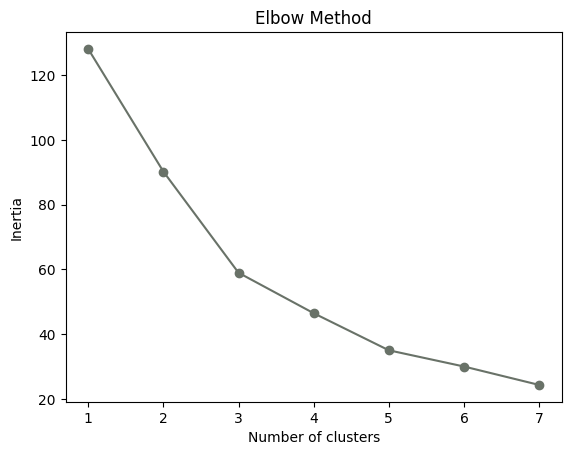

In [24]:
plt.plot(range(1,8), Sum_of_squared_distances, marker = 'o', c = '#697268')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

by the elbow plot, the optimum number of clusters is 3 or 5. we'll also do another analysis with the silhouette score:

In [33]:
def zoom_in_plot(X_train, y_pred, cluster_centers, sz, title:str):
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(5, 4, width_ratios=[5, 1, 3, 1], height_ratios=[1, 1, 1, 1, 1])  # Changed to 5 rows

    for yi in range(5):  # Iterate over 5 clusters
        # Main plot with more width
        ax = plt.subplot(gs[yi, 0])
        for xx in X_train[y_pred == yi]:  
            ax.plot(xx.ravel(), "k-", alpha=0.2)
        ax.plot(pca.inverse_transform(cluster_centers)[yi].ravel(), "r-")  # Plot cluster centers in original data space
        ax.set_xlim(0, sz)
        ax.set_ylim(-4, 4)
        ax.text(0.55, 0.85, 'Cluster %d' % (yi + 1), transform=ax.transAxes)
        if yi == 0:
            ax.set_title(f"{title}")

        # Zoomed-in plot
        axins = plt.subplot(gs[yi, 2])
        for xx in X_train[y_pred == yi]:  
            axins.plot(xx.ravel(), "k-", alpha=0.2)
        axins.plot(pca.inverse_transform(cluster_centers)[yi].ravel(), "r-")  # Plot cluster centers in original data space
        axins.set_xlim(200, 220)
        axins.set_ylim(-3, 3)
        mark_inset(ax, axins, loc1=2, loc2=3, fc="None", ec="g")

    # Adjust spacing between the two plots in the same row
    plt.subplots_adjust(wspace=0)

    # plt.tight_layout()
    plt.show()


For n_clusters = 2 The average silhouette_score is : 0.30
For n_clusters = 3 The average silhouette_score is : 0.31
For n_clusters = 4 The average silhouette_score is : 0.30
For n_clusters = 5 The average silhouette_score is : 0.36


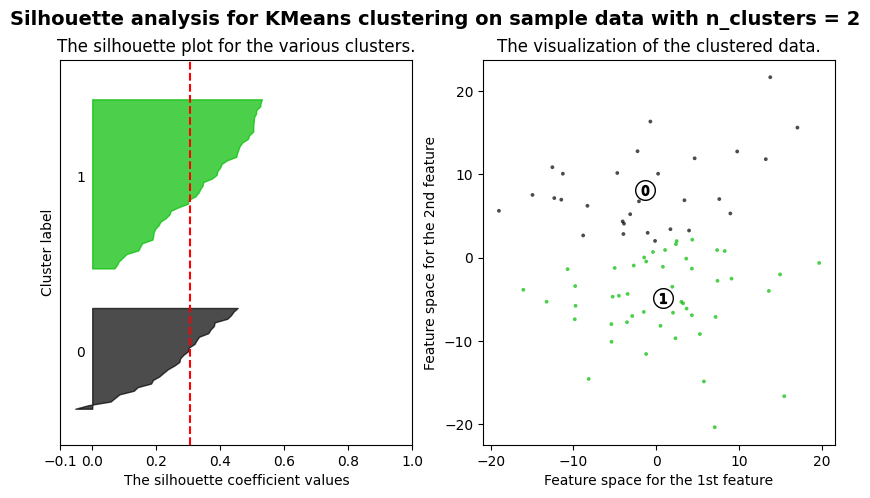

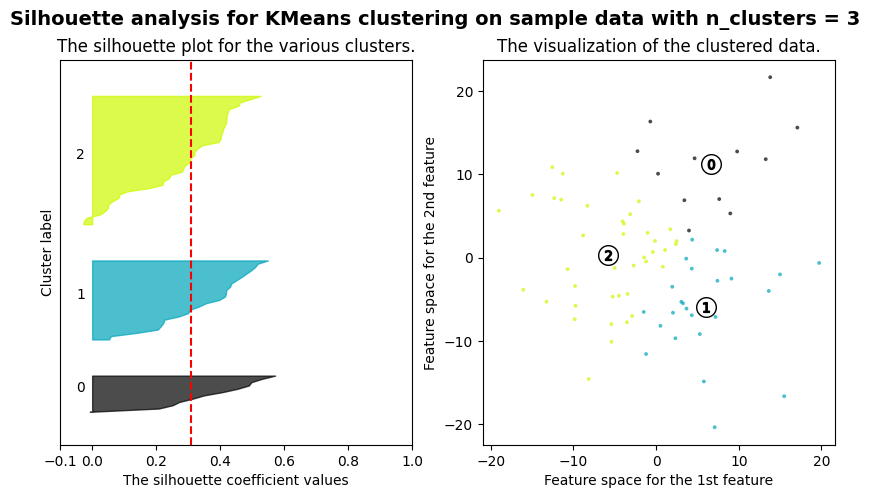

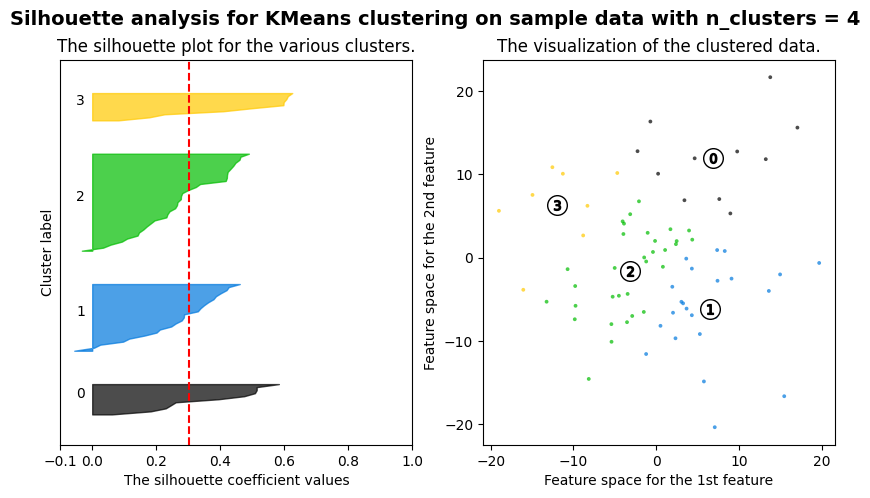

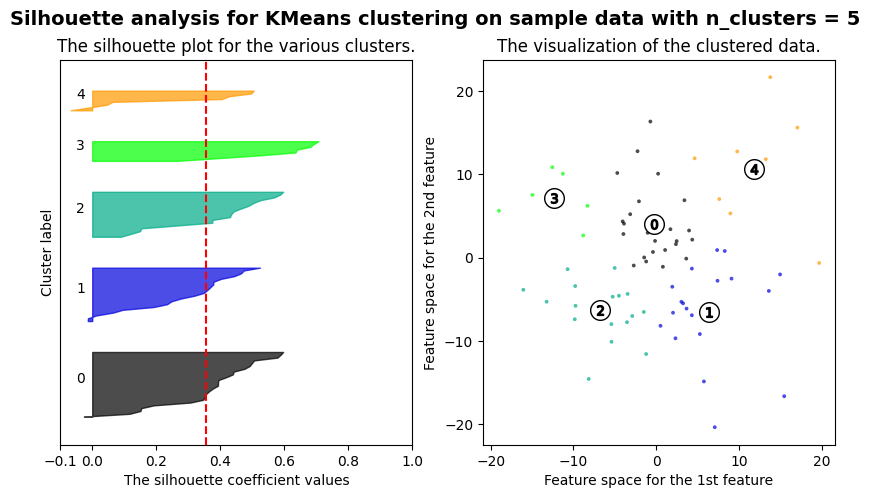

In [26]:
X = train_pca

range_n_clusters = [2,3,4,5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = TimeSeriesKMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is : {:.2f}"
        .format(silhouette_avg),
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


we have to look not only to the average silhouette score, but also for the partition that has the best silhouette score for the individual clusters

using 5 clusters as is the best in the silhouette analysis

Euclidean k-means
44.239 --> 38.888 --> 37.637 --> 37.438 --> 37.438 --> 


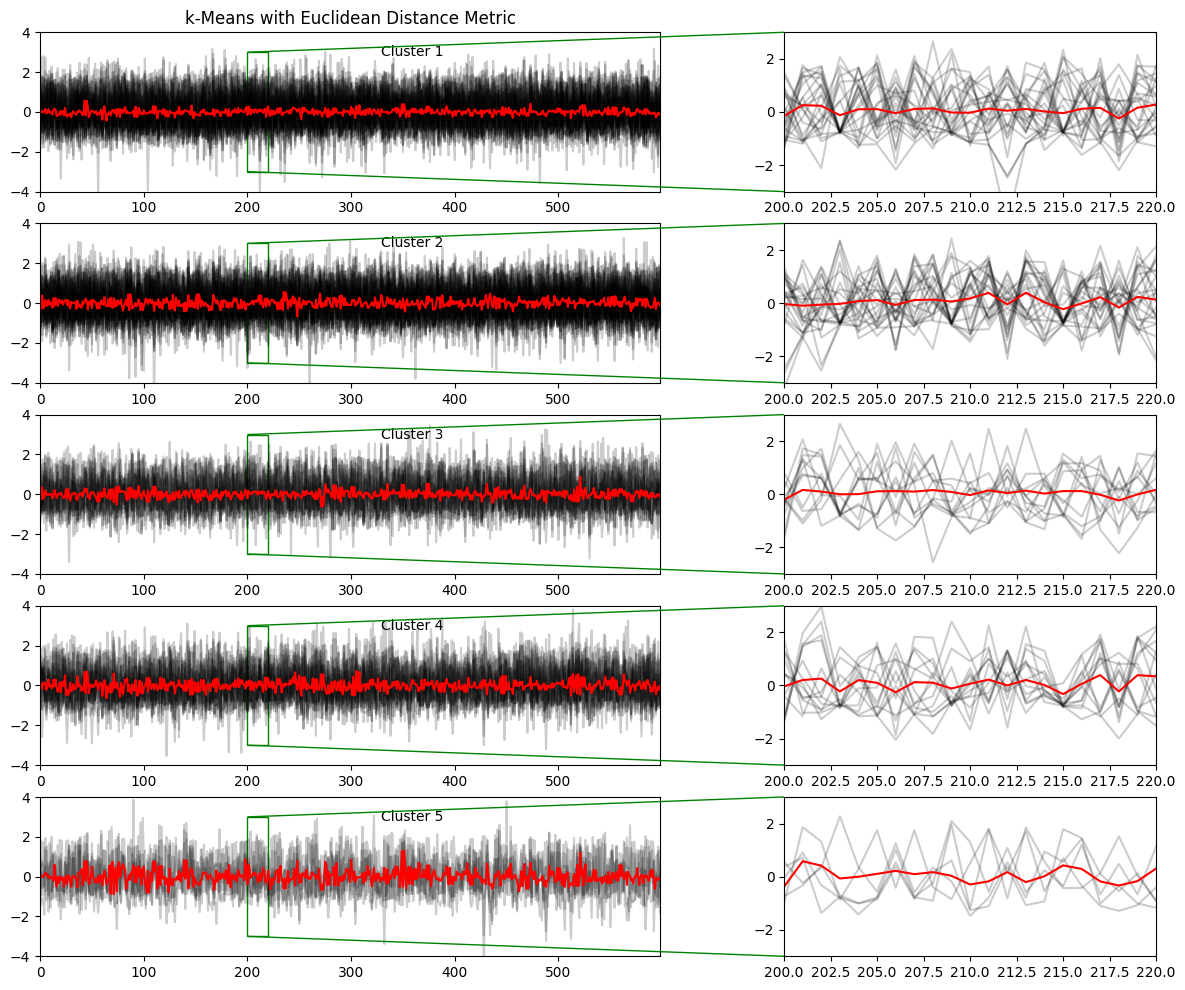

In [34]:
# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=5, verbose=True, random_state=seed)
y_pred_euclidean = km.fit_predict(train_pca)

cluster_centers_reshaped = km.cluster_centers_.reshape(5, 2)

#zoom_in_plot(X_train, y_pred_euclidean, km, sz, 'k-Means with Euclidean Distance Metric')
zoom_in_plot(X_train, y_pred_euclidean, cluster_centers_reshaped, sz, 'k-Means with Euclidean Distance Metric')


In [35]:
with open('intermediate_with_out/euclidean_solar.pickle', 'wb') as f:
    pickle.dump(km, f)

with open('intermediate_with_out/euclidean_labels.pickle', 'wb') as f:
    pickle.dump(y_pred_euclidean, f)

In [468]:
with open('intermediate_with_out/euclidean_solar.pickle', 'rb') as f:
    km = pickle.load(f)

with open('intermediate_with_out/euclidean_labels.pickle', 'rb') as f:
    y_pred_euclidean = pickle.load(f)

In [36]:
assets_per_cluster_euclidean = pd.DataFrame()

assets_per_cluster_euclidean['asset_id'] = df_subset['asset_id'].unique()
assets_per_cluster_euclidean['cluster_label'] = y_pred_euclidean

In [37]:
assets_clusters = assets_per_cluster_euclidean.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [1, 3, 7, 8, 9, 14, 15, 28, 30, 31, 32, 36, 38, 42, 44, 45, 48, 49, 58, 61, 68, 73, 76]
Cluster 1: [10, 13, 16, 17, 18, 20, 21, 23, 24, 26, 27, 39, 40, 46, 47, 53, 54, 56, 59, 60, 67, 71, 72, 74]
Cluster 2: [0, 2, 4, 6, 29, 43, 50, 55, 63, 66, 70, 75]
Cluster 3: [5, 11, 12, 19, 22, 25, 33, 34, 37, 51, 52, 64, 65]
Cluster 4: [35, 41, 57, 62, 69]


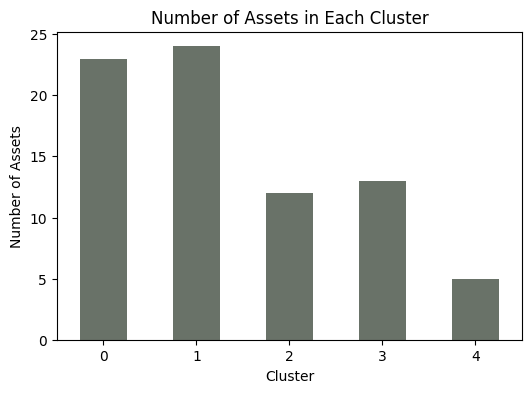

In [38]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_per_cluster_euclidean['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [42]:
asset_per_cluster = pd.DataFrame(columns=['Metric', 'Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])

for cluster_label, count in cluster_counts.items():
    column_name = f'Cluster {cluster_label}'  # Generate column name dynamically
    asset_per_cluster.loc[0, column_name] = int(count)

asset_per_cluster.loc[0, 'Metric'] = 'Euclidean'

asset_per_cluster

,Metric,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,Euclidean,23,24,12,13,5


In [43]:
merged_df = df_subset.merge(assets_per_cluster_euclidean, on='asset_id', how='left')

In [44]:
merged_df.to_csv('intermediate_with_out/results_clean_solar_euclidean.csv', index = False)

### k-Means with DTW distance metric

In [48]:
# dtw-k-means
print("dtw k-means")
dtw_km = TimeSeriesKMeans(n_clusters=5,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)

y_pred_dtw = dtw_km.fit_predict(train_pca)

dtw k-means
Init 1
40.571 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

35.790 --> 35.623 --> 35.623 --> 
Init 2


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


44.985 --> 39.717 --> 38.052 --> 37.340 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


35.914 --> 35.264 --> 35.173 --> 34.994 --> 

[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


34.994 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


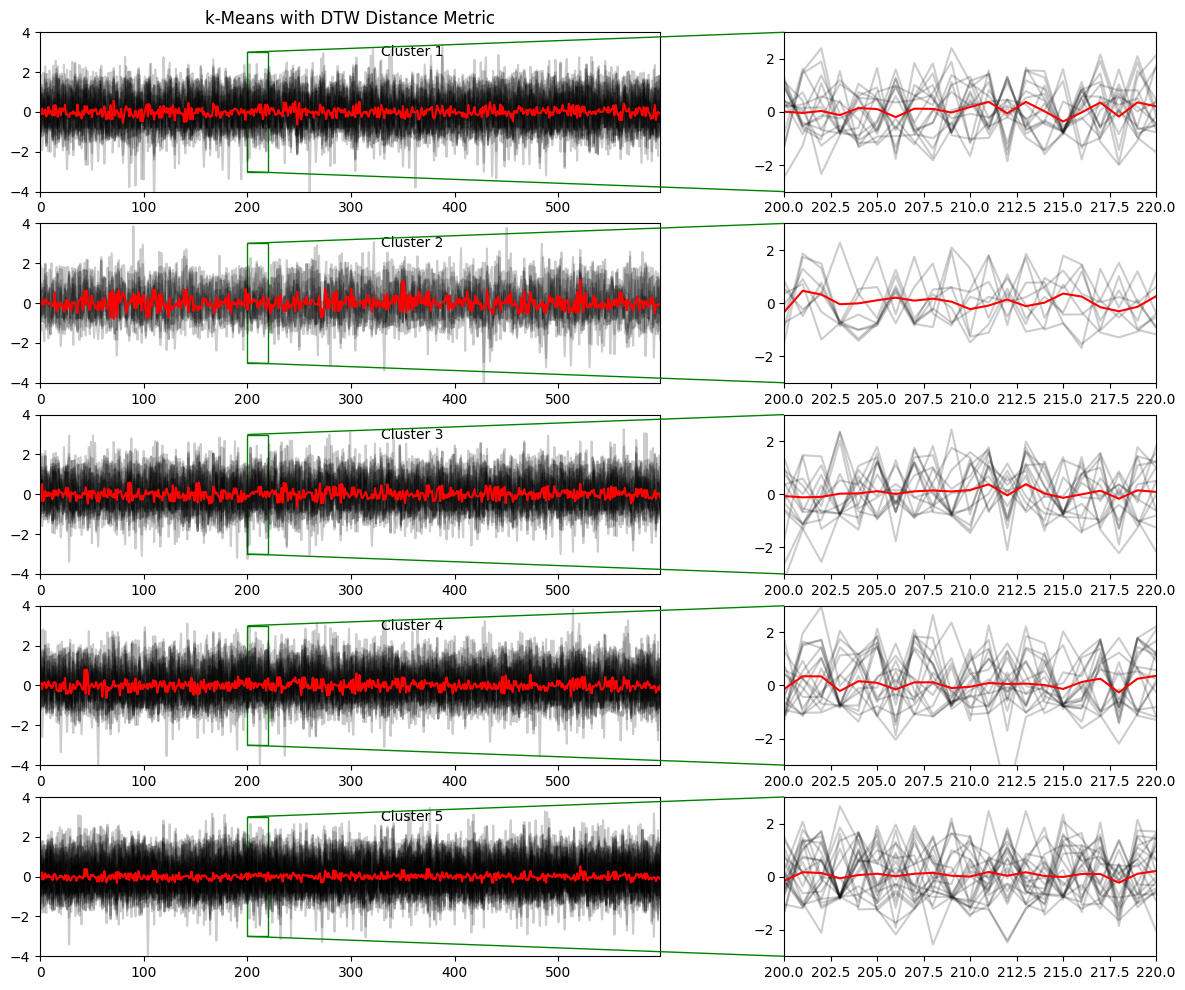

In [49]:
cluster_centers_reshaped = dtw_km.cluster_centers_.reshape(5, 2)

#zoom_in_plot(X_train, y_pred_euclidean, km, sz, 'k-Means with Euclidean Distance Metric')
zoom_in_plot(X_train, y_pred_dtw, cluster_centers_reshaped, sz, 'k-Means with DTW Distance Metric')

In [50]:
with open('intermediate_with_out/dtw_solar.pickle', 'wb') as f:
    pickle.dump(dtw_km, f)

with open('intermediate_with_out/dtw_labels.pickle', 'wb') as f:
    pickle.dump(y_pred_dtw, f)

In [460]:
with open('intermediate_with_out/dtw_solar.pickle', 'rb') as f:
    dtw_km = pickle.load(f)

with open('intermediate_with_out/dtw_labels.pickle', 'rb') as f:
    y_pred_dtw = pickle.load(f)

In [51]:
assets_per_cluster_dtw = pd.DataFrame()

assets_per_cluster_dtw['asset_id'] = df_subset['asset_id'].unique()
assets_per_cluster_dtw['cluster_label'] = y_pred_dtw

In [52]:
assets_clusters = assets_per_cluster_dtw.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [11, 13, 17, 19, 20, 22, 23, 33, 37, 39, 40, 45, 47, 54, 72, 74]
Cluster 1: [2, 35, 41, 50, 57, 62, 69, 75]
Cluster 2: [0, 10, 16, 18, 21, 24, 26, 27, 46, 53, 56, 59, 60, 67]
Cluster 3: [1, 5, 12, 15, 25, 28, 31, 34, 42, 44, 51, 52, 58, 61, 64, 65, 68]
Cluster 4: [3, 4, 6, 7, 8, 9, 14, 29, 30, 32, 36, 38, 43, 48, 49, 55, 63, 66, 70, 71, 73, 76]


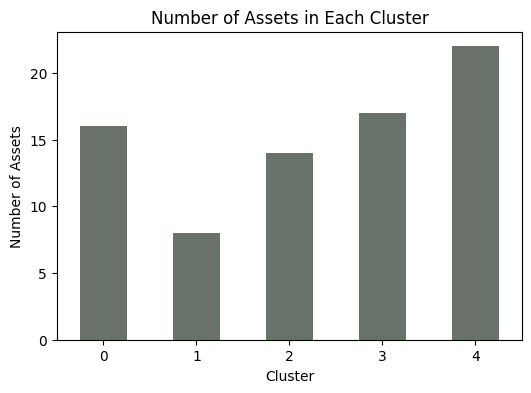

In [53]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_per_cluster_dtw['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [54]:
for cluster_label, count in cluster_counts.items():
    column_name = f'Cluster {cluster_label}'  # Generate column name dynamically
    asset_per_cluster.loc[1, column_name] = count

asset_per_cluster.loc[1, 'Metric'] = 'Dtw'

asset_per_cluster

,Metric,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,Euclidean,23,24,12,13,5
1,Dtw,16,8,14,17,22


In [55]:
merged_df = df_subset.merge(assets_per_cluster_dtw, on='asset_id', how='left')

In [56]:
merged_df.to_csv('intermediate_with_out/results_clean_solar_dtw.csv', index = False)

## Soft DTW k-means

In [57]:
# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=5,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
                           
y_pred_soft_dtw = sdtw_km.fit_predict(train_pca)

Soft-DTW k-means
4994.363 --> 3359.843 --> 3128.560 --> 3036.296 --> 3081.852 --> 2971.400 --> 2971.400 --> 


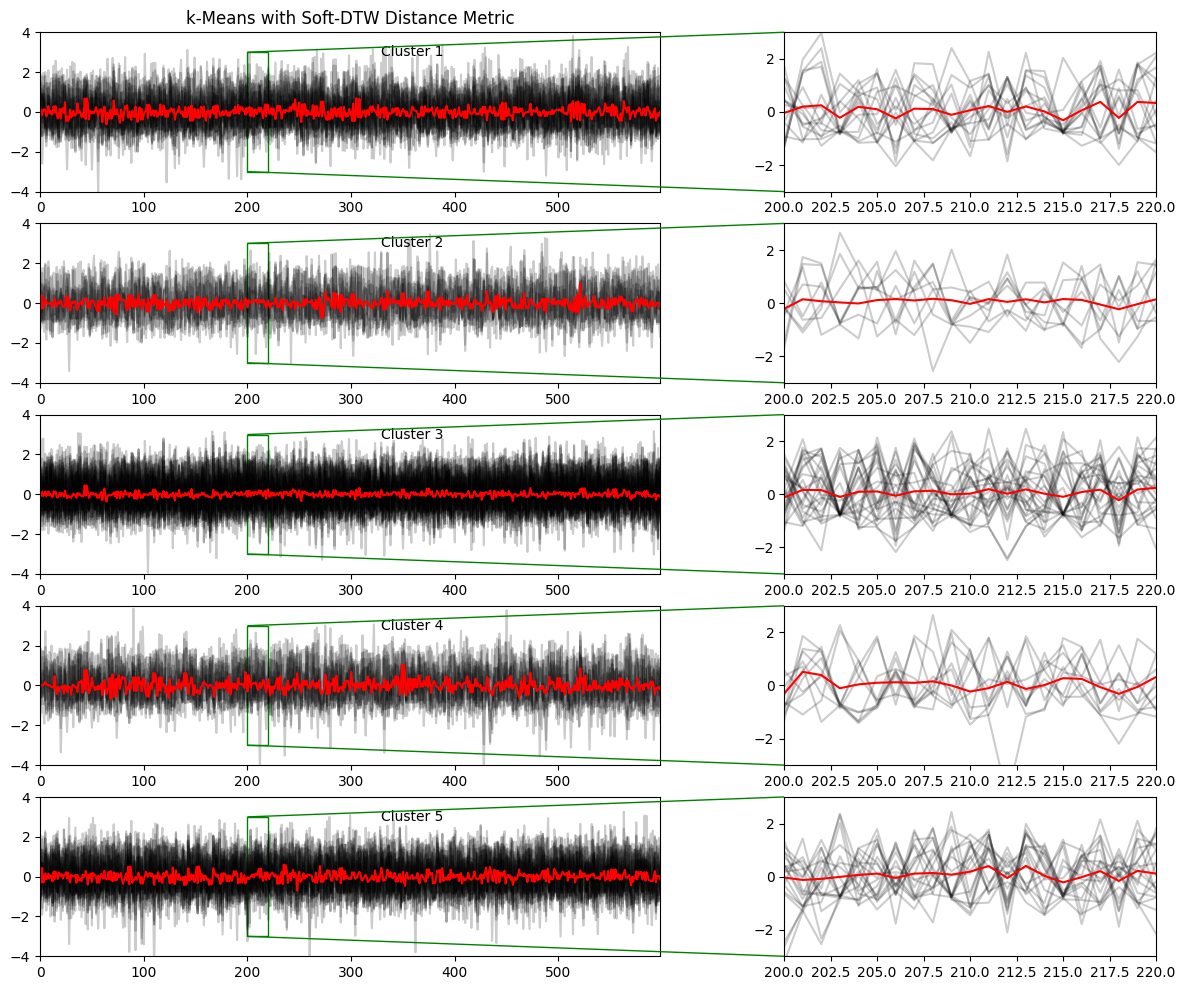

In [58]:
cluster_centers_reshaped = sdtw_km.cluster_centers_.reshape(5, 2)

#zoom_in_plot(X_train, y_pred_euclidean, km, sz, 'k-Means with Euclidean Distance Metric')
zoom_in_plot(X_train, y_pred_soft_dtw, cluster_centers_reshaped, sz, 'k-Means with Soft-DTW Distance Metric')

In [59]:
with open('intermediate_with_out/SDTW_solar.pickle', 'wb') as f:
    pickle.dump(sdtw_km, f)

with open('intermediate_with_out/SDTW_labels.pickle', 'wb') as f:
    pickle.dump(y_pred_soft_dtw, f)

In [475]:
with open('intermediate_with_out/SDTW_solar.pickle', 'rb') as f:
    sdtw_km = pickle.load(f)

with open('intermediate_with_out/SDTW_labels.pickle', 'rb') as f:
    y_pred_soft_dtw = pickle.load(f)

In [60]:
assets_per_cluster_soft_dtw = pd.DataFrame()

assets_per_cluster_soft_dtw['asset_id'] = df_subset['asset_id'].unique()
assets_per_cluster_soft_dtw['cluster_label'] = y_pred_soft_dtw

In [61]:
assets_clusters = assets_per_cluster_soft_dtw.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [5, 11, 12, 19, 22, 25, 33, 34, 37, 44, 47, 51, 52, 64, 65]
Cluster 1: [0, 2, 4, 29, 43, 50, 63, 70]
Cluster 2: [1, 3, 6, 7, 8, 9, 14, 15, 17, 28, 30, 32, 36, 38, 45, 48, 54, 55, 58, 61, 66, 71, 73, 74, 76]
Cluster 3: [31, 35, 41, 42, 49, 57, 62, 68, 69, 75]
Cluster 4: [10, 13, 16, 18, 20, 21, 23, 24, 26, 27, 39, 40, 46, 53, 56, 59, 60, 67, 72]


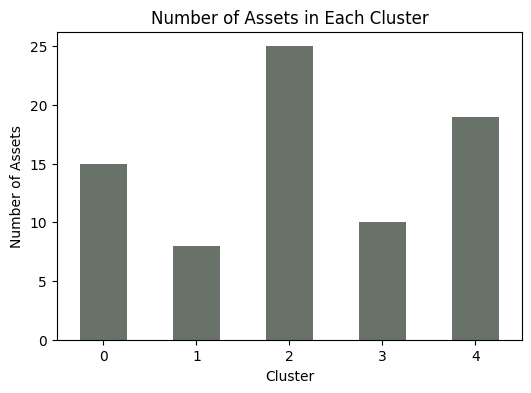

In [62]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_per_cluster_soft_dtw['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [63]:
for cluster_label, count in cluster_counts.items():
    column_name = f'Cluster {cluster_label}'  # Generate column name dynamically
    asset_per_cluster.loc[2, column_name] = count

asset_per_cluster.loc[2, 'Metric'] = 'Soft DTW'

asset_per_cluster

,Metric,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,Euclidean,23,24,12,13,5
1,Dtw,16,8,14,17,22
2,Soft DTW,15,8,25,10,19


In [64]:
merged_df = df_subset.merge(assets_per_cluster_soft_dtw, on='asset_id', how='left')

In [65]:
merged_df.to_csv('intermediate_with_out/results_clean_solar_soft_dtw.csv', index = False)

# Evaluation

In [66]:
def compute_silhouette_score(data = train_pca, y_pred = y_pred_euclidean, metric: str = 'euclidean'):
    silhouette = silhouette_score(data, y_pred, metric=metric)
    formatted_silhouette = f'{silhouette * 100:.2f}%'
    print(f'Silhouette score for {metric} metric: {formatted_silhouette}')

In [67]:
compute_silhouette_score()
compute_silhouette_score(y_pred=y_pred_dtw, metric='dtw')
compute_silhouette_score(y_pred=y_pred_soft_dtw, metric='softdtw')

Silhouette score for euclidean metric: 32.55%
Silhouette score for dtw metric: 34.23%
Silhouette score for softdtw metric: 45.03%
